# Packages

In [1]:
!pip install torchmetrics --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

2023-10-02 02:04:26.558853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 02:04:27.173913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 35
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("moses")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

In [9]:

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2222445
Valid Tokens:  243937
Test Tokens:  279249
Total number of tokens: 2745631


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 33264


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:

train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)


# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, hidden = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, hidden = self.rnn2(output,hidden)
    output = self.dropout2(output)
    
    output, hidden = self.rnn3(output,hidden)
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
model = model.to(device)

loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model

Trainable Parameters: 39.309264



H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 2540/2540 [05:37<00:00,  7.53batch/s, loss=6.05, perplexity=619]    


Valid: Loss = 5.178 Perplexity= 187.9, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 2540/2540 [05:49<00:00,  7.27batch/s, loss=5.45, perplexity=244]


Valid: Loss = 4.864 Perplexity= 136.8, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 2540/2540 [05:58<00:00,  7.08batch/s, loss=5.12, perplexity=175]


Valid: Loss = 4.636 Perplexity= 108.6, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 2540/2540 [06:00<00:00,  7.05batch/s, loss=4.84, perplexity=132]


Valid: Loss = 4.363 Perplexity= 82.73, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 2540/2540 [06:02<00:00,  7.01batch/s, loss=4.58, perplexity=102]


Valid: Loss = 4.178 Perplexity= 68.71, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 2540/2540 [06:03<00:00,  6.99batch/s, loss=4.37, perplexity=82.2]


Valid: Loss = 4.02 Perplexity= 58.66, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 2540/2540 [05:42<00:00,  7.42batch/s, loss=4.18, perplexity=68.6]


Valid: Loss = 3.888 Perplexity= 51.45, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.01, perplexity=57.6]


Valid: Loss = 3.766 Perplexity= 45.45, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=3.87, perplexity=49.9]


Valid: Loss = 3.644 Perplexity= 40.25, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=3.74, perplexity=44]  


Valid: Loss = 3.585 Perplexity= 37.88, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=3.63, perplexity=39.3]


Valid: Loss = 3.489 Perplexity= 34.4, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=3.53, perplexity=35.5]


Valid: Loss = 3.408 Perplexity= 31.66, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=3.43, perplexity=31.9]


Valid: Loss = 3.341 Perplexity= 29.65, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=3.33, perplexity=29]  


Valid: Loss = 3.241 Perplexity= 26.78, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=3.23, perplexity=26.2]


Valid: Loss = 3.162 Perplexity= 24.74, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=3.13, perplexity=23.7]


Valid: Loss = 3.077 Perplexity= 22.72, LR = 0.5
Model Saved!



Epoch 16: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=3.07, perplexity=22.4]


Valid: Loss = 2.995 Perplexity= 20.9, LR = 0.5
Model Saved!



Epoch 17: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=2.96, perplexity=19.9]


Valid: Loss = 2.922 Perplexity= 19.44, LR = 0.5
Model Saved!



Epoch 18: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=2.89, perplexity=18.6]


Valid: Loss = 2.897 Perplexity= 18.96, LR = 0.5
Model Saved!



Epoch 19: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=2.81, perplexity=17.2]


Valid: Loss = 2.828 Perplexity= 17.66, LR = 0.5
Model Saved!



Epoch 20: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=2.72, perplexity=15.7]


Valid: Loss = 2.735 Perplexity= 16.1, LR = 0.5
Model Saved!



Epoch 21: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=2.69, perplexity=15.3]


Valid: Loss = 2.731 Perplexity= 16.04, LR = 0.5
Model Saved!



Epoch 22: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=2.66, perplexity=14.7]


Valid: Loss = 2.68 Perplexity= 15.23, LR = 0.5
Model Saved!



Epoch 23: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=2.76, perplexity=16.5]


Valid: Loss = 2.814 Perplexity= 17.44, LR = 0.5



Epoch 24: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=2.32, perplexity=10.5]


Valid: Loss = 2.385 Perplexity= 11.31, LR = 0.25
Model Saved!



Epoch 25: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=2.18, perplexity=9.13]


Valid: Loss = 2.335 Perplexity= 10.75, LR = 0.25
Model Saved!



Epoch 26: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=2.13, perplexity=8.62]


Valid: Loss = 2.346 Perplexity= 10.87, LR = 0.25



Epoch 27: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.99, perplexity=7.53]


Valid: Loss = 2.17 Perplexity= 9.093, LR = 0.125
Model Saved!



Epoch 28: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.92, perplexity=6.99]


Valid: Loss = 2.131 Perplexity= 8.748, LR = 0.125
Model Saved!



Epoch 29: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.87, perplexity=6.63]


Valid: Loss = 2.089 Perplexity= 8.383, LR = 0.125
Model Saved!



Epoch 30: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.84, perplexity=6.43]


Valid: Loss = 2.08 Perplexity= 8.306, LR = 0.125
Model Saved!



Epoch 31: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.79, perplexity=6.15]


Valid: Loss = 2.04 Perplexity= 7.981, LR = 0.125
Model Saved!



Epoch 32: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.76, perplexity=5.96]


Valid: Loss = 2.017 Perplexity= 7.793, LR = 0.125
Model Saved!



Epoch 33: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.73, perplexity=5.76]


Valid: Loss = 2.004 Perplexity= 7.691, LR = 0.125
Model Saved!



Epoch 34: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.7, perplexity=5.6]  


Valid: Loss = 1.983 Perplexity= 7.527, LR = 0.125
Model Saved!



Epoch 35: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.68, perplexity=5.46]


Valid: Loss = 1.968 Perplexity= 7.417, LR = 0.125
Model Saved!



Epoch 36: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.66, perplexity=5.34]


Valid: Loss = 1.956 Perplexity= 7.324, LR = 0.125
Model Saved!



Epoch 37: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=1.63, perplexity=5.21]


Valid: Loss = 1.941 Perplexity= 7.212, LR = 0.125
Model Saved!



Epoch 38: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.61, perplexity=5.08]


Valid: Loss = 1.909 Perplexity= 6.989, LR = 0.125
Model Saved!



Epoch 39: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.59, perplexity=5]   


Valid: Loss = 1.905 Perplexity= 6.955, LR = 0.125
Model Saved!



Epoch 40: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.57, perplexity=4.87]


Valid: Loss = 1.893 Perplexity= 6.867, LR = 0.125
Model Saved!



Epoch 41: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.55, perplexity=4.8] 


Valid: Loss = 1.876 Perplexity= 6.756, LR = 0.125
Model Saved!



Epoch 42: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.63, perplexity=5.22]


Valid: Loss = 2.097 Perplexity= 8.467, LR = 0.125



Epoch 43: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.42, perplexity=4.22]


Valid: Loss = 1.755 Perplexity= 5.97, LR = 0.0625
Model Saved!



Epoch 44: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.39, perplexity=4.07]


Valid: Loss = 1.741 Perplexity= 5.886, LR = 0.0625
Model Saved!



Epoch 45: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.35, perplexity=3.93]


Valid: Loss = 1.718 Perplexity= 5.752, LR = 0.0625
Model Saved!



Epoch 46: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.33, perplexity=3.85]


Valid: Loss = 1.711 Perplexity= 5.705, LR = 0.0625
Model Saved!



Epoch 47: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.32, perplexity=3.78]


Valid: Loss = 1.699 Perplexity= 5.634, LR = 0.0625
Model Saved!



Epoch 48: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.681 Perplexity= 5.535, LR = 0.0625
Model Saved!



Epoch 49: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=1.29, perplexity=3.7] 


Valid: Loss = 1.685 Perplexity= 5.557, LR = 0.0625



Epoch 50: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.24, perplexity=3.49]


Valid: Loss = 1.623 Perplexity= 5.216, LR = 0.03125
Model Saved!



Epoch 51: 100%|██████████| 2540/2540 [06:02<00:00,  7.02batch/s, loss=1.22, perplexity=3.42]


Valid: Loss = 1.614 Perplexity= 5.173, LR = 0.03125
Model Saved!



Epoch 52: 100%|██████████| 2540/2540 [06:00<00:00,  7.04batch/s, loss=1.21, perplexity=3.4] 


Valid: Loss = 1.598 Perplexity= 5.087, LR = 0.03125
Model Saved!



Epoch 53: 100%|██████████| 2540/2540 [06:05<00:00,  6.94batch/s, loss=1.2, perplexity=3.36] 


Valid: Loss = 1.59 Perplexity= 5.044, LR = 0.03125
Model Saved!



Epoch 54: 100%|██████████| 2540/2540 [06:05<00:00,  6.94batch/s, loss=1.19, perplexity=3.33]


Valid: Loss = 1.58 Perplexity= 4.996, LR = 0.03125
Model Saved!



Epoch 55: 100%|██████████| 2540/2540 [06:05<00:00,  6.96batch/s, loss=1.19, perplexity=3.32]


Valid: Loss = 1.578 Perplexity= 4.982, LR = 0.03125
Model Saved!



Epoch 56: 100%|██████████| 2540/2540 [06:04<00:00,  6.96batch/s, loss=1.18, perplexity=3.29]


Valid: Loss = 1.566 Perplexity= 4.924, LR = 0.03125
Model Saved!



Epoch 57: 100%|██████████| 2540/2540 [06:04<00:00,  6.97batch/s, loss=1.17, perplexity=3.26]


Valid: Loss = 1.56 Perplexity= 4.894, LR = 0.03125
Model Saved!



Epoch 58: 100%|██████████| 2540/2540 [06:04<00:00,  6.98batch/s, loss=1.16, perplexity=3.23]


Valid: Loss = 1.558 Perplexity= 4.885, LR = 0.03125
Model Saved!



Epoch 59: 100%|██████████| 2540/2540 [05:55<00:00,  7.15batch/s, loss=1.15, perplexity=3.21]


Valid: Loss = 1.554 Perplexity= 4.865, LR = 0.03125
Model Saved!



Epoch 60: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.15, perplexity=3.19]


Valid: Loss = 1.536 Perplexity= 4.777, LR = 0.03125
Model Saved!



Epoch 61: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.14, perplexity=3.16]


Valid: Loss = 1.533 Perplexity= 4.761, LR = 0.03125
Model Saved!



Epoch 62: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.13, perplexity=3.14]


Valid: Loss = 1.534 Perplexity= 4.764, LR = 0.03125



Epoch 63: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.1, perplexity=3.05] 


Valid: Loss = 1.5 Perplexity= 4.6, LR = 0.015625
Model Saved!



Epoch 64: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.1, perplexity=3.02] 


Valid: Loss = 1.494 Perplexity= 4.572, LR = 0.015625
Model Saved!



Epoch 65: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.11, perplexity=3.07]


Valid: Loss = 1.499 Perplexity= 4.597, LR = 0.015625



Epoch 66: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.11, perplexity=3.08]


Valid: Loss = 1.484 Perplexity= 4.532, LR = 0.0078125
Model Saved!



Epoch 67: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.12, perplexity=3.09]


Valid: Loss = 1.471 Perplexity= 4.468, LR = 0.0078125
Model Saved!



Epoch 68: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.11, perplexity=3.07]


Valid: Loss = 1.468 Perplexity= 4.453, LR = 0.0078125
Model Saved!



Epoch 69: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.1, perplexity=3.05] 


Valid: Loss = 1.464 Perplexity= 4.436, LR = 0.0078125
Model Saved!



Epoch 70: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.09, perplexity=3.02]


Valid: Loss = 1.457 Perplexity= 4.405, LR = 0.0078125
Model Saved!



Epoch 71: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.09, perplexity=3]   


Valid: Loss = 1.455 Perplexity= 4.397, LR = 0.0078125
Model Saved!



Epoch 72: 100%|██████████| 2540/2540 [05:25<00:00,  7.82batch/s, loss=1.08, perplexity=2.99]


Valid: Loss = 1.455 Perplexity= 4.397, LR = 0.0078125



Epoch 73: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.08, perplexity=2.99]


Valid: Loss = 1.433 Perplexity= 4.301, LR = 0.00390625
Model Saved!



Epoch 74: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.08, perplexity=2.98]


Valid: Loss = 1.43 Perplexity= 4.285, LR = 0.00390625
Model Saved!



Epoch 75: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.07, perplexity=2.96]


Valid: Loss = 1.427 Perplexity= 4.274, LR = 0.00390625
Model Saved!



Epoch 76: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.07, perplexity=2.96]


Valid: Loss = 1.426 Perplexity= 4.27, LR = 0.00390625
Model Saved!



Epoch 77: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.07, perplexity=2.94]


Valid: Loss = 1.425 Perplexity= 4.266, LR = 0.00390625
Model Saved!



Epoch 78: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.07, perplexity=2.94]


Valid: Loss = 1.419 Perplexity= 4.24, LR = 0.00390625
Model Saved!



Epoch 79: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.06, perplexity=2.93]


Valid: Loss = 1.421 Perplexity= 4.249, LR = 0.00390625



Epoch 80: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.07, perplexity=2.94]


Valid: Loss = 1.409 Perplexity= 4.193, LR = 0.001953125
Model Saved!



Epoch 81: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.06, perplexity=2.93]


Valid: Loss = 1.406 Perplexity= 4.181, LR = 0.001953125
Model Saved!



Epoch 82: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.06, perplexity=2.92]


Valid: Loss = 1.404 Perplexity= 4.175, LR = 0.001953125
Model Saved!



Epoch 83: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.06, perplexity=2.92]


Valid: Loss = 1.402 Perplexity= 4.165, LR = 0.001953125
Model Saved!



Epoch 84: 100%|██████████| 2540/2540 [05:25<00:00,  7.82batch/s, loss=1.06, perplexity=2.91]


Valid: Loss = 1.402 Perplexity= 4.163, LR = 0.001953125
Model Saved!



Epoch 85: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.06, perplexity=2.91]


Valid: Loss = 1.402 Perplexity= 4.164, LR = 0.001953125



Epoch 86: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.06, perplexity=2.92]


Valid: Loss = 1.394 Perplexity= 4.131, LR = 0.0009765625
Model Saved!



Epoch 87: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.06, perplexity=2.91]


Valid: Loss = 1.393 Perplexity= 4.126, LR = 0.0009765625
Model Saved!



Epoch 88: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.06, perplexity=2.9] 


Valid: Loss = 1.392 Perplexity= 4.123, LR = 0.0009765625
Model Saved!



Epoch 89: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.9] 


Valid: Loss = 1.393 Perplexity= 4.125, LR = 0.0009765625



Epoch 90: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.9] 


Valid: Loss = 1.39 Perplexity= 4.112, LR = 0.00048828125
Model Saved!



Epoch 91: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.9] 


Valid: Loss = 1.389 Perplexity= 4.109, LR = 0.00048828125
Model Saved!



Epoch 92: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.9] 


Valid: Loss = 1.388 Perplexity= 4.106, LR = 0.00048828125
Model Saved!



Epoch 93: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.89]


Valid: Loss = 1.388 Perplexity= 4.104, LR = 0.00048828125
Model Saved!



Epoch 94: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.89]


Valid: Loss = 1.387 Perplexity= 4.101, LR = 0.00048828125
Model Saved!



Epoch 95: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.89]


Valid: Loss = 1.386 Perplexity= 4.096, LR = 0.00048828125
Model Saved!



Epoch 96: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.89]


Valid: Loss = 1.386 Perplexity= 4.099, LR = 0.00048828125



Epoch 97: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.89]


Valid: Loss = 1.386 Perplexity= 4.096, LR = 0.000244140625
Model Saved!



Epoch 98: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.89]


Valid: Loss = 1.385 Perplexity= 4.093, LR = 0.000244140625
Model Saved!



Epoch 99: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.385 Perplexity= 4.094, LR = 0.000244140625



Epoch 100: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.385 Perplexity= 4.092, LR = 0.0001220703125
Model Saved!



Epoch 101: 100%|██████████| 2540/2540 [05:25<00:00,  7.80batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.385 Perplexity= 4.091, LR = 0.0001220703125
Model Saved!



Epoch 102: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.384 Perplexity= 4.09, LR = 0.0001220703125
Model Saved!



Epoch 103: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.384 Perplexity= 4.09, LR = 0.0001220703125
Model Saved!



Epoch 104: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.384 Perplexity= 4.09, LR = 0.0001220703125
Model Saved!



Epoch 105: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.384 Perplexity= 4.09, LR = 0.0001220703125
Model Saved!



Epoch 106: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.384 Perplexity= 4.089, LR = 0.0001220703125
Model Saved!



Epoch 107: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.384 Perplexity= 4.088, LR = 0.0001220703125
Model Saved!



Epoch 108: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.383 Perplexity= 4.087, LR = 0.0001220703125
Model Saved!



Epoch 109: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.383 Perplexity= 4.086, LR = 0.0001220703125
Model Saved!



Epoch 110: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.383 Perplexity= 4.086, LR = 0.0001220703125



Epoch 111: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.383 Perplexity= 4.086, LR = 6.103515625e-05



Epoch 112: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.383 Perplexity= 4.085, LR = 3.0517578125e-05
Model Saved!



Epoch 113: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.383 Perplexity= 4.086, LR = 3.0517578125e-05



Epoch 114: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.383 Perplexity= 4.085, LR = 1.52587890625e-05



Epoch 115: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.383 Perplexity= 4.085, LR = 7.62939453125e-06



Epoch 116: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.383 Perplexity= 4.085, LR = 3.814697265625e-06



Epoch 117: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.383 Perplexity= 4.085, LR = 1.9073486328125e-06
LR_DEC==3 , Finished


## Learning Curve

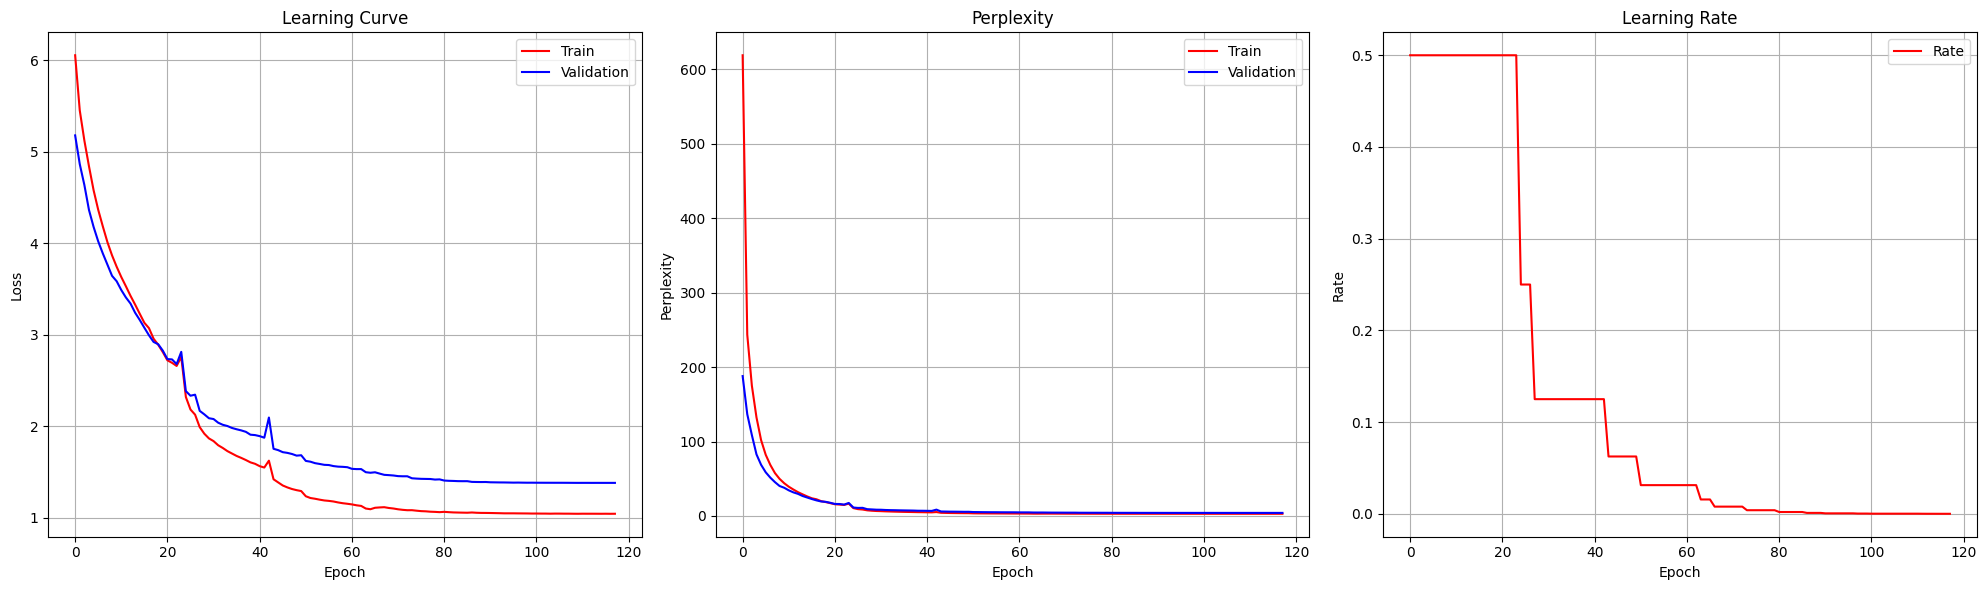

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
#LanguageModel = H_LSTM

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 1.383 , Perplexity = 4.085
Test: Loss = 1.318 , Perplexity = 3.855


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

In [22]:
num_trainable_params(model)

39.309264

In [23]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie , after originally double home through another indie female artist until he again played Star A May 4 ⁄ 9 – 0 after losing between her daughter and Jim and Jeff Harrison .
